# 用于手写数字识别的神经网络，多类

在本练习中，您将使用神经网络来识别手写数字0-9。

# 大纲
- [1 包]()
- [2 ReLU 激活]()
- [3 Softmax 函数]()
    - [练习1]()
- [4 神经网络]()
    - [4.1 问题陈述]()
    - [4.2 数据集]()
    - [4.3 模型表示]()
    - [4.4 Tensorflow模型实现]()
    - [4.5 Softmax放置]()
        - [练习2]()

## 1 套餐

首先，让我们运行下面的单元来导入您在此作业期间需要的所有包。

- [numpy](https://numpy.org/)是使用Python进行科学计算的基础包。
- [matplotlib](https://matplotlib.org)是一个流行的Python绘图库。
- [tensorflow](https://www.tensorflow.org/)一个流行的机器学习平台。

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
%matplotlib widget
import matplotlib.pyplot as plt

plt.style.use('./deeplearning.mplstyle')
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
from public_tests import *
from autils import *
from lab_utils_softmax import plt_softmax

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config, )
np.set_printoptions(precision=2)

## 2 ReLU激活

本周，引入了一种新的激活方法，即修正线性单元（ReLU）。

$$a=max(0,z)\quad\quad\text{ReLU函数}$$

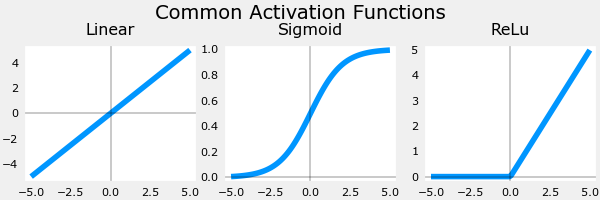

In [25]:
plt_act_trio()

<img align="right" src="../../images/C2_W2_ReLu.png" style="width:380px; padding: 10px 20px;">

右侧讲座中的示例展示了ReLU的应用。在此示例中，导出的“意识”特征不是二进制的，而是具有连续的值范围。sigmoid最适合开/关或二元情况。ReLU提供连续的线性关系。此外，它还有一个输出为零的“关闭”范围。

“关闭”功能使ReLU成为非线性激活。为什么需要这个？这使得多个单元能够在不干扰的情况下为最终的功能做出贡献。在支持的可选实验室中对此进行了更多检查。

## 3 Softmax函数

多类神经网络生成N个输出。选择一个输出作为预测答案。在输出层中，向量$\mathbf{z}$由线性函数生成，该线性函数被输入到softmax函数中。softmax函数将$\mathbf{z}$转换为概率分布，如下所述。应用 softmax后，每个输出将介于0和1之间，并且输出之和将为1。它们可以解释为概率。softmax的输入越大，对应的输出概率就越大。

<img src="../../images/C2_W2_NNSoftmax.PNG" width="600"/>

softmax函数可以写成：

$$a_j=\frac{e^{z_j}}{\sum_{k=0}^{N-1}{e^{z_k}}}\tag{1}$$

其中$z=\mathbf{w}\cdot\mathbf{x}+b$和N是输出层中特征/类别的数量。

### 练习1

让我们创建一个NumPy实现：

In [3]:
def my_softmax(z):
    es = np.exp(z)
    sum_exp = np.sum(es)
    return es / sum_exp

In [4]:
z = np.array([1., 2., 3., 4.])
a = my_softmax(z)
atf = tf.nn.softmax(z)
print(f"my_softmax(z):         {a}")
print(f"tensorflow softmax(z): {atf}")
test_my_softmax(my_softmax)

my_softmax(z):         [0.03 0.09 0.24 0.64]
tensorflow softmax(z): [0.03 0.09 0.24 0.64]
 All tests passed.


下面，改变`z`输入的值。特别注意分子中的指数如何放大值中的微小差异。另请注意，输出值之和为1。

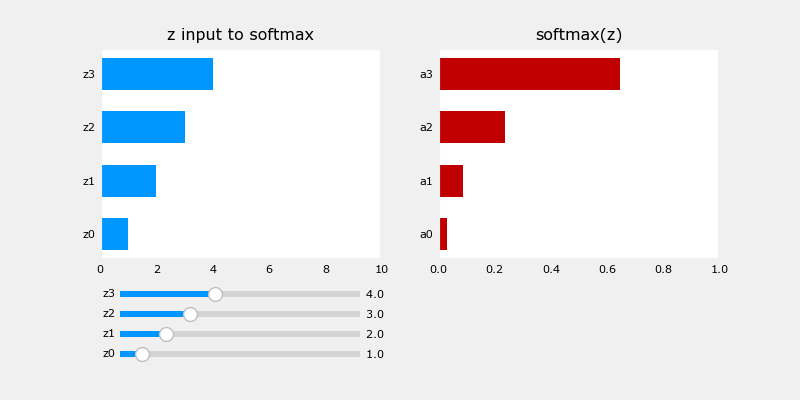

In [24]:
plt.close("all")
plt_softmax(my_softmax)

## 4 神经网络

在上周的作业中，您实现了一个神经网络来进行二元分类。本周您将把它扩展到多类分类。这将利用softmax激活。

### 4.1 问题陈述

在本练习中，您将使用神经网络来识别10个手写数字0-9。这是一个多类分类任务，其中选择n个选项之一。自动手写数字识别如今已得到广泛应用——从识别邮件信封上的邮政编码（邮政编码）到识别银行支票上的金额。

### 4.2 数据集

您将首先加载此任务的数据集。

- 下面显示的`load_data()`函数将数据加载到变量`X`和`y`中
- 数据集包含5000个手写数字$^1$的训练示例。
    - 每个训练示例都是数字的20像素x20像素灰度图像。
        - 每个像素都由浮点数表示，指示该位置的灰度强度。
        - 20x20像素网格“展开”为400维向量。
        - 每个训练示例都成为数据矩阵`X`中的一行。
        - 这为我们提供了一个5000x400矩阵`X`，其中每一行都是手写数字图像的训练示例。

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 
- 训练集的第二部分是一个5000x1维向量`y`，其中包含训练集的标签
    - 如果图像是数字`0`，则`y = 0`；如果图像是数字`4`，则`y = 4`，依此类推。

$^1$<sub>这是MNIST手写数字数据集的子集（https://yann.lecun.com/exdb/mnist/）</sub>

In [6]:
X, y = load_data()

#### 4.2.1 查看变量

让我们更熟悉您的数据集。

- 一个好的起点是打印出每个变量并查看它包含的内容。

下面的代码打印变量`X`和`y`中的第一个元素。

In [7]:
print('The first element of X is: ', X[0])

The first element of X is:  [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  0.00e+00  0.00e+00  8.56e-06  1.94e-06 -7.37e-04
 -8.13e-03 -1.86e-02 -1.87e-02 -1.88e-02 -1.91e-02 -1.64e-02 -3.78e-03
  3.30e-04  1.28e-05  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
  0.00e+00  0.00e+00  1.16e-04  1.20e-04 -1.40e-02 -2.85e-02  8.04e-02
  2.67e-01  2.74e-01  2.79e-01  2.74e-01  2.25e-0

In [8]:
print('The first element of y is: ', y[0, 0])
print('The last element of y is: ', y[-1, 0])

The first element of y is:  0
The last element of y is:  9


#### 4.2.2 检查变量的维度

熟悉数据的另一种方法是查看其维度。请打印`X`和`y`的形状，并查看数据集中有多少个训练示例。

In [9]:
print('The shape of X is: ' + str(X.shape))
print('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


#### 4.2.3 可视化数据

您将首先可视化训练集的子集。

- 在下面的单元格中，代码从`X`中随机选择64行，将每行映射回20像素x20像素的灰度图像，并将图像一起显示。
- 每个图像的标签显示在图像上方

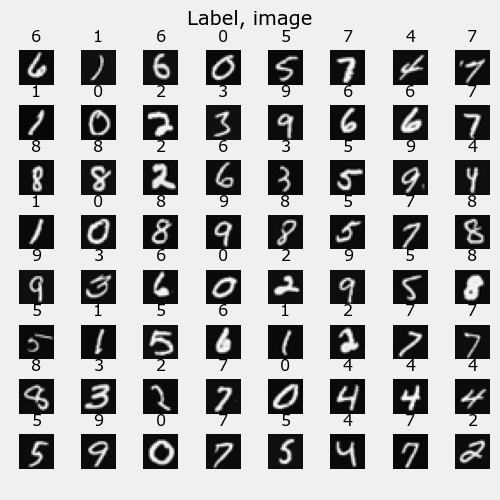

In [23]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])
widgvis(fig)
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

### 4.3 模型表示

您将在本次作业中使用的神经网络如下图所示。

- 它有两个带有ReLU激活的密集层，后面跟着一个带有线性激活的输出层。
    - 回想一下，我们的输入是数字图像的像素值。
    - 由于图像大小为$20\times20$，这为我们提供了$400$输入
    
<img src="../../images/C2_W2_Assigment_NN.png" width="600" height="450">


- 参数的尺寸适合神经网络，第1层为$25$单位，第2层为$15$单位，第3层为$10$输出单位，每个数字一个。
    - 回想一下，这些参数的维度确定如下：
        - 如果网络在一层中有$s_{in}$单元，在下一层有$s_{out}$单元，则
            - $W$的尺寸为$s_{in}\times s_{out}$。
            - $b$将是一个带有$s_{out}$元素的向量
    - 因此，`W`和`b`的形状是
        - 第1层：`W1`的形状为`(400, 25)`，`b1`的形状为`(25,)`
        - 第2层：`W2`的形状是`(25, 15)`，`b2`的形状是：`(15,)`
        - 第3层：`W3`的形状是`(15, 10)`，`b3`的形状是：`(10,)`

>**注意：** 偏差向量b可以表示为一维`(n,)`或二维`(n,1)`数组。Tensorflow使用一维表示，本实验室将维持该约定：

### 4.4 Tensorflow模型实现

Tensorflow模型是逐层构建的。图层的输入尺寸（上面的$s_{in}$）是为您计算的。您指定图层的*输出尺寸*，这决定了下一层的输入尺寸。第一层的输入维度源自下面`model.fit`语句中指定的输入数据的大小。

>**注意：** 还可以添加一个输入层，指定第一层的输入维度。例如：`tf.keras.Input(shape=(400,)), #指定输入形状`我们将在这里添加它来说明一些模型尺寸。

### 4.5 Softmax放置

正如讲座和可选的softmax实验室中所述，如果在训练期间将softmax与损失函数而不是输出层分组，则数值稳定性会得到提高。这在“构建”模型和“使用”模型时会产生影响。

建筑：

* 最终的密集层应该使用“线性”激活。这实际上是没有激活。
* `model.compile`语句将通过包含`from_logits=True`来表明这一点。

  `loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`
* 这不会影响目标的形状。对于SparseCategorialCrossentropy，目标是预期的数字0-9。

使用模型：

* 输出不是概率。如果需要输出概率，请应用softmax函数。

### 练习2

下面，使用Keras[顺序模型](https://keras.io/guides/sequential_model/)和[密集层](https://keras.io/api/layers/core_layers/dense/)以及ReLU激活来构建上述三层网络。

In [11]:
tf.random.set_seed(1234)
model = Sequential(
    [tf.keras.Input(shape=(400,)), Dense(25, activation='relu', name='L1'), Dense(15, activation='relu', name='L2'),
     Dense(10, activation='linear', name='L3')], name="my_model")


In [12]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


In [13]:
test_model(model, 10, 400)

All tests passed!


摘要中显示的参数计数对应于权重和偏差数组中的元素数量，如下所示。

让我们进一步检查权重，以验证张量流产生的尺寸与我们上面计算的尺寸相同。

In [14]:
[layer1, layer2, layer3] = model.layers

In [15]:
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


**期望输出**

```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 1), b3 shape = (10,)
```

下面的代码：

* 定义一个损失函数`SparseCategoricalCrossentropy`，并通过添加`from_logits=True`指示softmax应包含在损失计算中）
* 定义一个优化器。一个流行的选择是讲座中描述的自适应矩（Adam）。

In [16]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(X, y, epochs=100)

Epoch 1/100
157/157 [==============================] - 2s 1ms/step - loss: 1.5662
Epoch 2/100
157/157 [==============================] - 0s 1ms/step - loss: 0.6439
Epoch 3/100
157/157 [==============================] - 0s 1ms/step - loss: 0.4486
Epoch 4/100
157/157 [==============================] - 0s 1ms/step - loss: 0.3678
Epoch 5/100
157/157 [==============================] - 0s 1ms/step - loss: 0.3244
Epoch 6/100
157/157 [==============================] - 0s 1ms/step - loss: 0.2925
Epoch 7/100
157/157 [==============================] - 0s 1ms/step - loss: 0.2662
Epoch 8/100
157/157 [==============================] - 0s 1ms/step - loss: 0.2441
Epoch 9/100
157/157 [==============================] - 0s 1ms/step - loss: 0.2274
Epoch 10/100
157/157 [==============================] - 0s 1ms/step - loss: 0.2060
Epoch 11/100
157/157 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 12/100
157/157 [==============================] - 0s 1ms/step - loss: 0.1846
Epoch 13/100


#### 纪元和批次

在上面的`compile`语句中，`epochs`的数量设置为100。这指定整个数据集在训练期间应应用100次。在训练期间，您会看到描述训练进度的输出，如下所示：

```
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss：2.2770
```

第一行`Epoch 1/100`描述了模型当前运行的纪元。为了提高效率，训练数据集被分成“批次”。Tensorflow中批次的默认大小为32。我们的数据集中有5000个示例，即大约157个批次。第二行`157/157 [====`上的符号描述了哪个批次已被执行。

#### 损失（成本）

在课程1中，我们学会了通过监控成本来跟踪梯度下降的进度。理想情况下，随着算法迭代次数的增加，成本将会降低。Tensorflow将成本称为`loss`。在上面，您看到了执行`model.fit`时每个时期显示的损失。[.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) 方法返回各种指标，包括损失。这是在上面的`history`变量中捕获的。这可用于检查图中的损失，如下所示。

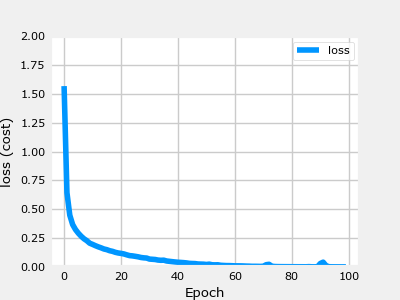

In [17]:
plot_loss_tf(history)

#### 预言

要进行预测，请使用Keras`predict`。下面，`X[1015]`包含一个二的图像。

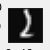

1/1 [==============================] - 0s 12ms/step
 predicting a Two: 
[[-20.93   3.09   8.5    0.72 -19.48  -7.87  -8.41   3.41 -16.64 -12.86]]
 Largest Prediction index: 2


In [26]:
image_of_two = X[1015]
display_digit(image_of_two)
prediction = model.predict(image_of_two.reshape(1, 400))
print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

最大的输出是预测`[2]`，表示预测的数字是“2”。如果问题只需要选择，那就足够了。使用NumPy[argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)选择它。如果问题需要概率，则需要softmax：

In [19]:
prediction_p = tf.nn.softmax(prediction)
print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[1.64e-13 4.46e-03 9.89e-01 4.16e-04 6.98e-13 7.70e-08 4.51e-08 6.12e-03
  1.19e-11 5.25e-10]]
Total of predictions: 1.000


要返回表示预测目标的整数，您需要最大概率的索引。这是通过Numpy argmax函数完成的。

In [20]:
yhat = np.argmax(prediction_p)
print(f"np.argmax(prediction_p): {yhat}")

np.argmax(prediction_p): 2


让我们比较64位随机样本的预测与标签。这需要一些时间来运行。

1/1 [==============================] - 0s 11ms/step


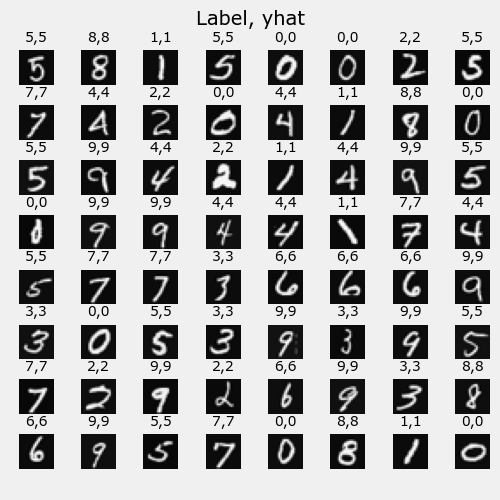

In [21]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(5, 5))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])
widgvis(fig)
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    prediction = model.predict(X[random_index].reshape(1, 400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    ax.set_title(f"{y[random_index, 0]},{yhat}", fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

让我们看看其中的一些错误。

>注意：增加训练时期的数量可以消除该数据集上的错误。

In [22]:
print(f"{display_errors(model, X, y)} errors out of {len(X)} images")

157/157 [==============================] - 0s 646us/step
no errors found
0 errors out of 5000 images


### 恭喜！

您已成功构建并利用神经网络进行多类分类。